#LIBRERIAS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd

In [ ]:
import pickle

#GENERACIÓN DE DATOS

##FUNCIONES

###TRANSFORMACIONES

In [ ]:
def w_2_so3(w):
  w1 = w[0]
  w2 = w[1]
  w3 = w[2]
  wt = np.array([[0, -w3, w2],
                 [w3, 0, -w1],
                 [-w2, w1, 0]])
  return wt

def so3_2_w(w):
  return np.array([w[-1,1],w[0,-1],w[1,0]])

In [ ]:
def t_2_se3(s):
  M = np.zeros((4,4))
  M[:3,:3] = w_2_so3(s[:3])
  M[:3,-1] = s[3:]
  return M

def se3_2_t(s):
  w_hat = s[:3,:3]
  v = s[:3,-1]
  return np.concatenate((so3_2_w(w_hat),v))

In [ ]:
def R(w_hat,theta):
  return np.eye(3) + np.sin(theta)*w_hat + (1-np.cos(theta))*w_hat@w_hat

def p(w_hat,theta,v):
  R_int = np.eye(3)*theta + (1-np.cos(theta))*w_hat + (theta-np.sin(theta))*w_hat@w_hat
  return R_int@v

def G(w_hat,theta):
  G = np.eye(3)/theta - 0.5*w_hat + (1/theta - 0.5/np.tan(theta/2))*w_hat@w_hat
  return G

In [ ]:
def w_2_SO3(w,theta):
  return R(w_2_so3(w),theta)

def SO3_2_w(R):
  if np.trace(R)+1<=1e-10:
    theta = np.pi
    w = (1/(2*(1+R[0,0])**.5))*np.array([1+R[0,0],R[1,0],R[2,0]])
  else:
    theta = np.arccos(0.5*(np.trace(R)-1))
    w = so3_2_w((1/(2*np.sin(theta)))*(R-R.T))
  return w,theta

In [ ]:
def SE3_2_t(TH):
  w,theta = SO3_2_w(TH[:3,:3])
  w_hat = w_2_so3(w)
  v = G(w_hat,theta)@TH[:3,-1]
  return np.concatenate((w,v)), theta

def t_2_SE3(t,theta):
  w = t[:3]
  v = t[3:]
  w_hat = w_2_so3(w)
  Ri = R(w_hat,theta)
  pi = p(w_hat,theta,v)
  TH = np.eye(4)
  TH[:3,:3] = Ri
  TH[:-1,-1] = pi
  return TH

In [ ]:
def cr_param(M):
    return -(np.eye(3) - M)@np.linalg.inv(np.eye(3) + M)

In [ ]:
def ct_param(M):
    return -(np.eye(4) - M)@np.linalg.inv(np.eye(4) + M)

In [ ]:
def lie_bracket_t(A,B):
  A = t_2_se3(A)
  B = t_2_se3(B)
  lb = A@B-B@A
  return se3_2_t(lb)

###VECTORES

In [ ]:
def spherical_vector(ndim=3):
    vec = np.random.randn(ndim)
    vec /= np.linalg.norm(vec, axis=-1)
    return vec

In [ ]:
def linear_vector(ndim=3, inf_limit=-1, sup_limit=1):
    vec = np.random.uniform(inf_limit, sup_limit, (ndim,))
    return vec

##BASE DE DATOS

In [ ]:
npoints = 100000 #numero de puntos
ndim = 3 #numero de dimensiones

In [ ]:
def data_gen():
  #vectores de rotacion (screws)
  w1 = spherical_vector(ndim)
  w2 = spherical_vector(ndim)

  #puntos de aplicacion del screw
  q1 = linear_vector(ndim)
  q2 = linear_vector(ndim)

  #expresion en se3 para velocidad lineal en rotacion pura
  v1 = np.cross(-w1,q1)
  v2 = np.cross(-w2,q2)

  theta1 = linear_vector(1, -np.pi, np.pi)
  theta2 = linear_vector(1, -np.pi, np.pi)

  #vector R6 de se3
  wv1 = np.concatenate((w1,v1))
  wv2 = np.concatenate((w2,v2))

  #primeros 6 componentes de Baker–Campbell–Hausdorff formula
  r1 = wv1*theta1/np.pi
  r2 = wv2*theta2/np.pi
  r12 = lie_bracket_t(r1,r2)
  r112 = lie_bracket_t(r1,r12)
  r221 = lie_bracket_t(r2,-r12)
  r2112 = lie_bracket_t(r2,r112)

  #producto escalar
  dr1r2 = np.dot(r1[:3],r2[:3])

  #composicion de transformaciones
  TH1 = t_2_SE3(wv1,theta1)
  TH2 = t_2_SE3(wv2,theta2)
  TH3 = TH1@TH2
  wv3,theta3 = SE3_2_t(TH3)

  r3 = wv3*theta3/np.pi

  #calculo de coeficientes Ax=b
  #matriz A
  A = np.vstack((r1,r2,r12,r112,r221,r2112)).T

  #coeficientes "x"
  c = np.linalg.pinv(A) @ r3

  return np.concatenate((r1,r2,r12,r112,r221,r2112,[dr1r2],theta1,theta2,c,r3,[theta3]))

In [ ]:
data = np.array([data_gen() for _ in range(npoints)])

In [ ]:
print(data.shape)

(100000, 51)


In [ ]:
# datos
#X = data[:,0:39]
c = data[:,-13:-7]
dr1r2 =  data[:,-16]
theta1 = data[:,-15]/np.pi
theta2 = data[:,-14]/np.pi
dv1v2 = np.sum(data[:,3:6]*data[:,9:12], axis=1)
dw1v2 = np.sum(data[:,0:3]*data[:,9:12], axis=1)
dw2v1 = np.sum(data[:,6:9]*data[:,3:6], axis=1)

y = c
#X = np.hstack((dr1r2[..., np.newaxis],theta1[..., np.newaxis]**2,theta2[..., np.newaxis]**2,theta1[..., np.newaxis],theta2[..., np.newaxis],dv1v2[..., np.newaxis]))
#X = np.hstack((dr1r2[..., np.newaxis],theta1[..., np.newaxis]**2,theta2[..., np.newaxis]**2,theta1[..., np.newaxis],theta2[..., np.newaxis],dw1v2[..., np.newaxis],dw2v1[..., np.newaxis]))
X = np.hstack((dr1r2[..., np.newaxis],theta1[..., np.newaxis],theta2[..., np.newaxis]))

In [ ]:
# rms de la aproximacion de coeficientes
r3_1 = data[:,-7:-1]
r12_1 = data[:,0:36].reshape((npoints,6,6))
r12_1 = np.transpose(r12_1, (0, 2, 1))
r3_1_pred = r12_1@c[..., np.newaxis]
print(np.mean((r3_1-r3_1_pred.squeeze(-1))**2))

3.405488732402595e-21


In [ ]:
# @title COEFICIENTES GRAFICA 1
fig = go.Figure(layout={'template':'plotly_dark'})
fig.add_trace(go.Scatter(y=c[:1000,0],
                         name='c1'))
fig.add_trace(go.Scatter(y=c[:1000,1],
                         name='c2'))
fig.add_trace(go.Scatter(y=c[:1000,2],
                         name='c3'))
fig.add_trace(go.Scatter(y=c[:1000,3],
                         name='c4'))
fig.add_trace(go.Scatter(y=c[:1000,4],
                         name='c5'))
fig.add_trace(go.Scatter(y=c[:1000,5],
                         name='c6'))

# Set layout
fig.update_layout(
    title_text=f"coeficientes",
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

# Add range slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))

fig.show()

In [ ]:
# @title COEFICIENTES GRAFICA 2

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}]])

fig.add_trace(go.Scatter3d(
            x=c[:5000,3],
            y=c[:5000,4],
            z=c[:5000,5],
            mode='markers',
            name='c_345',
            marker=dict(size=3,
                        color=dr1r2[:5000],
                        showscale=True,
                        colorscale='Viridis',
                        colorbar=dict(len=1.05, x=0.4 ,y=0.49),
                        ),
            ),row=1, col=1)

fig.add_trace(go.Scatter3d(
            x=c[:5000,0],
            y=c[:5000,1],
            z=c[:5000,2],
            mode='markers',
            name='c_012',
            marker=dict(size=3,
                        color=(c[:5000,2]>0)*1,
                        showscale=True,
                        colorscale='viridis',
                        colorbar=dict(len=1.05, x=1.1 ,y=0.49),
                        ),
            ),row=1, col=2)


# Set layout
fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

# Add range slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)),
                  template='plotly_dark')

fig.show()

In [ ]:
# @title COEFICIENTES GRAFICA 2

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}]])

fig.add_trace(go.Scatter3d(
            x=theta1[:5000],
            y=theta2[:5000],
            z=dr1r2[:5000],
            mode='markers',
            name='c_0',
            marker=dict(size=3,
                        color=c[:5000,3],
                        showscale=True,
                        colorscale='Viridis',
                        colorbar=dict(len=1.05, x=0.4 ,y=0.49),
                        ),
            ),row=1, col=1)

fig.add_trace(go.Scatter3d(
            x=theta1[:5000]**2,
            y=theta2[:5000]**2,
            z=dr1r2[:5000],
            mode='markers',
            name='c_012',
            marker=dict(size=3,
                        color=(c[:5000,2]>0)*1,
                        showscale=True,
                        colorscale='viridis',
                        colorbar=dict(len=1.05, x=1.1 ,y=0.49),
                        ),
            ),row=1, col=2)


# Set layout
fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

# Add range slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)),
                  template='plotly_dark')

fig.show()

#RED NEURONAL

##LIBRERIAS

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC

##PARAMETROS DEL MODELO

In [ ]:
#@title

porcentaje_de_datos_para_entrenamiento = 90 #@param {type:"slider", min:0, max:100, step:1}

# Variables de trabajo

train_percent = porcentaje_de_datos_para_entrenamiento/100

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_percent, random_state=100)

In [ ]:
bool_mask_train = y_train[:,2]>0
bool_mask_test = y_test[:,2]>0

mask_train = bool_mask_train*1
mask_test = bool_mask_test*1

Xp_train = X_train[bool_mask_train]
Xp_test = X_test[bool_mask_test]

Xn_train = X_train[~bool_mask_train]
Xn_test = X_test[~bool_mask_test]

yp_train = y_train[bool_mask_train]
yp_test = y_test[bool_mask_test]

yn_train = y_train[~bool_mask_train]
yn_test = y_test[~bool_mask_test]

In [ ]:
# @title COEFICIENTES GRAFICA 1
fig = go.Figure(layout={'template':'plotly_dark'})
fig.add_trace(go.Scatter(y=yp_train[:1000,0],
                         name='c1'))
fig.add_trace(go.Scatter(y=yp_train[:1000,1],
                         name='c2'))
fig.add_trace(go.Scatter(y=yp_train[:1000,2],
                         name='c3'))
fig.add_trace(go.Scatter(y=yp_train[:1000,3],
                         name='c4'))
fig.add_trace(go.Scatter(y=yp_train[:1000,4],
                         name='c5'))
fig.add_trace(go.Scatter(y=yp_train[:1000,5],
                         name='c6'))

# Set layout
fig.update_layout(
    title_text=f"coeficientes",
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

# Add range slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))

fig.show()

In [ ]:
# @title COEFICIENTES GRAFICA 1
fig = go.Figure(layout={'template':'plotly_dark'})
fig.add_trace(go.Scatter(y=yn_train[:1000,0],
                         name='c1'))
fig.add_trace(go.Scatter(y=yn_train[:1000,1],
                         name='c2'))
fig.add_trace(go.Scatter(y=yn_train[:1000,2],
                         name='c3'))
fig.add_trace(go.Scatter(y=yn_train[:1000,3],
                         name='c4'))
fig.add_trace(go.Scatter(y=yn_train[:1000,4],
                         name='c5'))
fig.add_trace(go.Scatter(y=yn_train[:1000,5],
                         name='c6'))

# Set layout
fig.update_layout(
    title_text=f"coeficientes",
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

# Add range slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))

fig.show()

###CLASSIFICATION

In [ ]:
mask = Pipeline([('standardscaler', StandardScaler()),('svc', SVC())])
mask.fit(X_train[:,:3], mask_train).score(X_test[:,:3], mask_test)

0.9986

In [ ]:
mask = Pipeline([('scaler', StandardScaler()),('svc', SVC(gamma='auto'))])
mask.fit(X_train[:,:3], mask_train).score(X_test[:,:3], mask_test)

0.9986

In [ ]:
mask = Pipeline([('caler', StandardScaler()),('svc', SVC(C=10,gamma='auto'))])
mask.fit(X_train[:,:3], mask_train).score(X_test[:,:3], mask_test)

0.9991

In [ ]:
mask = Pipeline([('scaler', StandardScaler()),('svc', SVC(C=100,gamma='auto'))])
mask.fit(X_train[:,:3], mask_train).score(X_test[:,:3], mask_test)

0.9994

In [ ]:
mask = Pipeline([('scaler', StandardScaler()),('svc', SVC(C=10000))])
mask.fit(X_train[:,:3], mask_train).score(X_test[:,:3], mask_test)

0.9998

In [ ]:
pickle.dump(mask, open('mask.sav', 'wb'))

In [ ]:
loaded_mask = pickle.load(open('mask.sav', 'rb'))

####RESULTADOS

In [ ]:
mask_pred = mask.predict(X_test[:,:3])

In [ ]:
bool_mask_pred = np.array(mask_pred, dtype=bool)

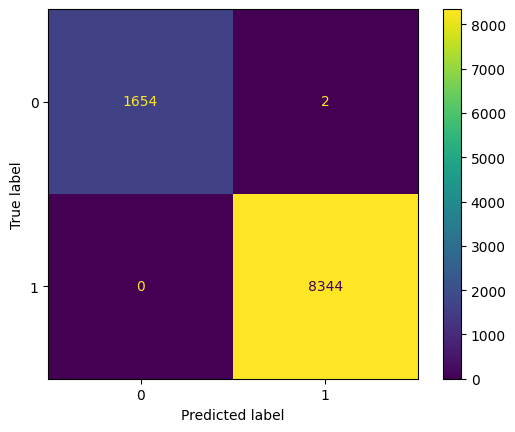

In [ ]:
ConfusionMatrixDisplay.from_predictions(mask_test, mask_pred)

In [ ]:
# @title PREDICCION MASCARA

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}]])

fig.add_trace(go.Scatter3d(
            x=y_test[:5000,0],
            y=y_test[:5000,1],
            z=y_test[:5000,2],
            mode='markers',
            name='true',
            marker=dict(size=3,
                        color=mask_test[:5000],
                        showscale=True,
                        colorscale='viridis',
                        colorbar=dict(len=1.05, x=1.1 ,y=0.49),
                        ),
            ),row=1, col=1)

fig.add_trace(go.Scatter3d(
            x=y_test[:5000,0],
            y=y_test[:5000,1],
            z=y_test[:5000,2],
            mode='markers',
            name='pred',
            marker=dict(size=3,
                        color=mask_pred[:5000],
                        showscale=True,
                        colorscale='viridis',
                        colorbar=dict(len=1.05, x=1.1 ,y=0.49),
                        ),
            ),row=1, col=2)

# Set layout
fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

# Add range slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)),
                  template='plotly_dark')

fig.show()

###REGRESSOR

####DATOS +

In [1]:
posNN = MLPRegressor(hidden_layer_sizes=[50,200,50,10,50,200,50], tol=1e-2, max_iter=500, random_state=0)
posNN.fit(Xp_train[:,:3], yp_train).score(Xp_test[:,:3], yp_test)

NameError: name 'MLPRegressor' is not defined

In [ ]:
posNN = MLPRegressor(hidden_layer_sizes=[50,200,50,10,50,200,50], tol=1e-2, max_iter=500, random_state=0)
posNN.fit(Xp_train, yp_train).score(Xp_test, yp_test)

0.9993859662174632

In [ ]:
posNN = Pipeline([('scaler', MinMaxScaler(feature_range=(-1,1))),('mlp', MLPRegressor(hidden_layer_sizes=[50,200,50,10,50,200,50], tol=1e-4, max_iter=1000, random_state=0))])
posNN.fit(Xp_train[:,:3], yp_train).score(Xp_test[:,:3], yp_test)

0.9995424261360578

In [ ]:
posNN = Pipeline([('scaler', MinMaxScaler(feature_range=(-1,1))),('mlp', MLPRegressor(hidden_layer_sizes=[100]*10, tol=1e-4, max_iter=1000, random_state=0))])
posNN.fit(Xp_train[:,:3], yp_train).score(Xp_test[:,:3], yp_test)

0.9988743098139334

In [ ]:
posNN = Pipeline([('scaler', MinMaxScaler(feature_range=(-1,1))),('mlp', MLPRegressor(hidden_layer_sizes=[100]*10, tol=1e-4, max_iter=1000, random_state=0))])
posNN.fit(Xp_train, yp_train).score(Xp_test, yp_test)

0.995829584925313

In [ ]:
pickle.dump(posNN, open('posNN.sav', 'wb'))

####DATOS -

In [ ]:
negNN = Pipeline([('scaler', MinMaxScaler(feature_range=(-1,1))),('mlp', MLPRegressor(hidden_layer_sizes=[100]*10, tol=1e-4, max_iter=1000, random_state=0))])
negNN.fit(Xn_train, yn_train[:,3:]).score(Xn_test, yn_test[:,3:])

0.9995536710369383

In [ ]:
negNN = Pipeline([('scaler', MinMaxScaler(feature_range=(0,1))),('mlp', MLPRegressor(hidden_layer_sizes=[100]*10, tol=1e-4, max_iter=1000, random_state=0))])
negNN.fit(Xn_train, yn_train).score(Xn_test, yn_test)

0.9993395578358317

In [ ]:
negNN = Pipeline([('scaler', MinMaxScaler(feature_range=(-1,1))),('mlp', MLPRegressor(hidden_layer_sizes=[100]*10, tol=1e-4, max_iter=1000, random_state=0))])
negNN.fit(Xn_train, yn_train).score(Xn_test, yn_test)

0.9996369250460683

In [ ]:
negNN = MLPRegressor(hidden_layer_sizes=[100]*10, tol=1e-2, max_iter=500, random_state=0)
negNN.fit(Xn_train, yn_train).score(Xn_test, yn_test)

0.9973989229209416

In [ ]:
negNN = Pipeline([('scaler', MinMaxScaler(feature_range=(-1,1))),('mlp', MLPRegressor(hidden_layer_sizes=[100]*10, tol=1e-4, max_iter=1000, random_state=0))])
negNN.fit(Xn_train, yn_train).score(Xn_test, yn_test)

0.9978845894076535

In [ ]:
negNN = MLPRegressor(hidden_layer_sizes=[50,200,200,50,10,50,200,200,50], tol=1e-2, max_iter=500, random_state=0)
negNN.fit(Xn_train, yn_train).score(Xn_test, yn_test)

0.9980255035589211

In [ ]:
negNN = Pipeline([('scaler', MinMaxScaler(feature_range=(-1,1))),('mlp', MLPRegressor(hidden_layer_sizes=[50,200,200,50,10,50,200,200,50], tol=1e-4, max_iter=1000, random_state=0))])
negNN.fit(Xn_train, yn_train).score(Xn_test, yn_test)

0.9991371729034907

In [ ]:
negNN = Pipeline([('scaler', MinMaxScaler(feature_range=(0,1))),('mlp', MLPRegressor(hidden_layer_sizes=[50,400,400,50,10,50,400,400,50], tol=1e-4, max_iter=1000, random_state=0))])
negNN.fit(Xn_train, yn_train).score(Xn_test, yn_test)

0.999278204024472

In [ ]:
negNN = Pipeline([('scaler', MinMaxScaler(feature_range=(-1,1))),('mlp', MLPRegressor(hidden_layer_sizes=[50,400,400,50,10,50,400,400,50], tol=1e-4, max_iter=1000, random_state=0))])
negNN.fit(Xn_train, yn_train).score(Xn_test, yn_test)

0.9994384725784591

In [ ]:
pickle.dump(negNN, open('negNN.sav', 'wb'))

####RESULTADOS

In [ ]:
yp_pred = posNN.predict(Xp_test[:,:3])

In [ ]:
rmse = np.sqrt(np.mean((yp_test-yp_pred)**2, axis=0))
print(rmse)

[0.00249497 0.00386115 0.00384683 0.00242956 0.00554305 0.0045639 ]


In [ ]:
yn_pred = negNN.predict(Xn_test)

In [ ]:
rmse = np.sqrt(np.mean((yn_test-yn_pred)**2, axis=0))
print(rmse)

[0.00901263 0.01040194 0.00815452 0.00787186 0.00725296 0.01192033]


In [ ]:
# @title COEFICIENTES PREDICCION POSITIVOS

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}],
                                           [{'type': 'scene'}, {'type': 'scene'}]])

fig.add_trace(go.Scatter3d(
            x=yp_test[:5000,3],
            y=yp_test[:5000,4],
            z=yp_test[:5000,5],
            mode='markers',
            name='y_test',
            marker=dict(size=3,
                        color="red"),
            ),row=1, col=1)

fig.add_trace(go.Scatter3d(
            x=yp_pred[:5000,3],
            y=yp_pred[:5000,4],
            z=yp_pred[:5000,5],
            mode='markers',
            name='y_pred',
            marker=dict(size=3,
                        color="green"),
            ),row=1, col=1)

fig.add_trace(go.Scatter3d(
            x=yp_test[:5000,0],
            y=yp_test[:5000,1],
            z=yp_test[:5000,2],
            mode='markers',
            name='y_test',
            marker=dict(size=3,
                        color="red"),
            ),row=1, col=2)

fig.add_trace(go.Scatter3d(
            x=yp_pred[:5000,0],
            y=yp_pred[:5000,1],
            z=yp_pred[:5000,2],
            mode='markers',
            name='y_pred',
            marker=dict(size=3,
                        color="green"),
            ),row=1, col=2)

fig.add_trace(go.Scatter3d(
            x=yp_pred[:5000,3]-yp_test[:5000,3],
            y=yp_pred[:5000,4]-yp_test[:5000,4],
            z=yp_pred[:5000,5]-yp_test[:5000,5],
            mode='markers',
            name='y_pred',
            marker=dict(size=3,
                        color=yp_pred[:5000,5]-yp_test[:5000,5],
                        colorscale='Viridis',
                        ),
            ),row=2, col=1)

fig.add_trace(go.Scatter3d(
            x=yp_pred[:5000,0]-yp_test[:5000,0],
            y=yp_pred[:5000,1]-yp_test[:5000,1],
            z=yp_pred[:5000,2]-yp_test[:5000,2],
            mode='markers',
            name='y_test',
            marker=dict(size=3,
                        color=yp_pred[:5000,2]-yp_test[:5000,2],
                        colorscale='Viridis',
                        ),
            ),row=2, col=2)




# Set layout
fig.update_layout(
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

# Add range slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)),
                  template='plotly_dark')

fig.show()

In [ ]:
# @title COEFICIENTES PREDICCION NEGATIVOS

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'scene'}, {'type': 'scene'}],
                                           [{'type': 'scene'}, {'type': 'scene'}]])

fig.add_trace(go.Scatter3d(
            x=yn_test[:5000,3],
            y=yn_test[:5000,4],
            z=yn_test[:5000,5],
            mode='markers',
            name='y_test',
            marker=dict(size=3,
                        color="red"),
            ),row=1, col=1)

fig.add_trace(go.Scatter3d(
            x=yn_pred[:5000,3],
            y=yn_pred[:5000,4],
            z=yn_pred[:5000,5],
            mode='markers',
            name='y_pred',
            marker=dict(size=3,
                        color="green"),
            ),row=1, col=1)

fig.add_trace(go.Scatter3d(
            x=yn_test[:5000,0],
            y=yn_test[:5000,1],
            z=yn_test[:5000,2],
            mode='markers',
            name='y_test',
            marker=dict(size=3,
                        color="red"),
            ),row=1, col=2)

fig.add_trace(go.Scatter3d(
            x=yn_pred[:5000,0],
            y=yn_pred[:5000,1],
            z=yn_pred[:5000,2],
            mode='markers',
            name='y_pred',
            marker=dict(size=3,
                        color="green"),
            ),row=1, col=2)

fig.add_trace(go.Scatter3d(
            x=yn_pred[:5000,3]-yn_test[:5000,3],
            y=yn_pred[:5000,4]-yn_test[:5000,4],
            z=yn_pred[:5000,5]-yn_test[:5000,5],
            mode='markers',
            name='y_pred',
            marker=dict(size=3,
                        color=yn_pred[:5000,5]-yn_test[:5000,5],
                        colorscale='Viridis',
                        ),
            ),row=2, col=1)

fig.add_trace(go.Scatter3d(
            x=yn_pred[:5000,0]-yn_test[:5000,0],
            y=yn_pred[:5000,1]-yn_test[:5000,1],
            z=yn_pred[:5000,2]-yn_test[:5000,2],
            mode='markers',
            name='y_test',
            marker=dict(size=3,
                        color=yn_pred[:5000,2]-yn_test[:5000,2],
                        colorscale='Viridis',
                        ),
            ),row=2, col=2)




# Set layout
fig.update_layout(
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

# Add range slider
fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)),
                  template='plotly_dark')

fig.show()

In [ ]:
#@title FUNCION DE PLOTEO
def plot_result(y_test,y_pred):
  fig = plt.figure(figsize=(12, 8))
  gs = fig.add_gridspec(2,3)
  ax1 = fig.add_subplot(gs[0, 0])
  ax2 = fig.add_subplot(gs[0, 1])
  ax3 = fig.add_subplot(gs[0, 2])
  ax4 = fig.add_subplot(gs[1, 0])
  ax5 = fig.add_subplot(gs[1, 1])
  ax6 = fig.add_subplot(gs[1, 2])

  ax1.plot(y_test[:,0], y_pred[:,0], 'or')
  ax1.plot(y_test[:,0],y_test[:,0], 'b')
  ax1.set_title('correlacion C1')
  ax1.grid()

  ax2.plot(y_test[:,1], y_pred[:,1], 'or')
  ax2.plot(y_test[:,1],y_test[:,1], 'b')
  ax2.set_title('correlacion C2')
  ax2.grid()

  ax3.plot(y_test[:,2], y_pred[:,2], 'or')
  ax3.plot(y_test[:,2],y_test[:,2], 'b')
  ax3.set_title('correlacion C3')
  ax3.grid()

  ax4.plot(y_test[:,3], y_pred[:,3], 'or')
  ax4.plot(y_test[:,3],y_test[:,3], 'b')
  ax4.set_title('correlacion C4')
  ax4.grid()

  ax5.plot(y_test[:,4], y_pred[:,4], 'or')
  ax5.plot(y_test[:,4],y_test[:,4], 'b')
  ax5.set_title('correlacion C5')
  ax5.grid()

  ax6.plot(y_test[:,5], y_pred[:,5], 'or')
  ax6.plot(y_test[:,5],y_test[:,5], 'b')
  ax6.set_title('correlacion C6')
  ax6.grid()

  plt.show()

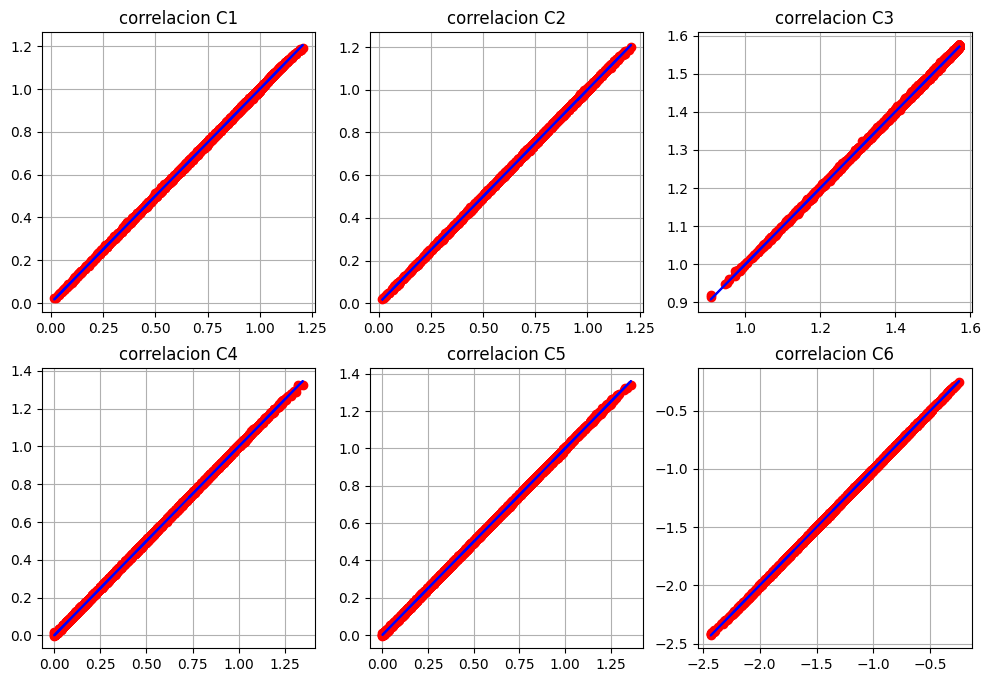

In [ ]:
plot_result(yp_test,yp_pred)

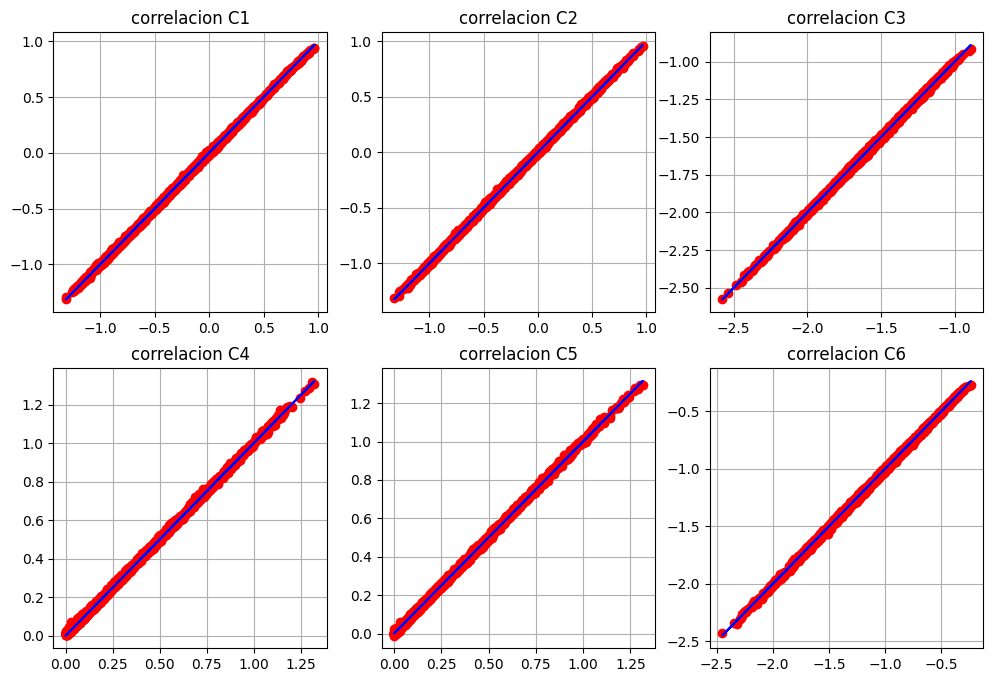

In [ ]:
plot_result(yn_test,yn_pred)

In [ ]:
def test_gen():
  #vectores de rotacion (screws)
  w1 = spherical_vector(ndim)
  w2 = spherical_vector(ndim)

  #puntos de aplicacion del screw
  q1 = linear_vector(ndim)
  q2 = linear_vector(ndim)

  #expresion en se3 para velocidad lineal en rotacion pura
  v1 = np.cross(-w1,q1)
  v2 = np.cross(-w2,q2)

  #vector R6 de se3
  wv1 = np.concatenate((w1,v1))
  wv2 = np.concatenate((w2,v2))

  return wv1, wv2

In [ ]:
wv1, wv2 = test_gen()

In [ ]:
print(np.dot(wv1, wv2)/(np.linalg.norm(wv1)*np.linalg.norm(wv2)))

-0.7162952498518464


In [ ]:
tx,ty = np.linspace(-np.pi, np.pi, 40), np.linspace(-np.pi, np.pi, 40)
u,v = np.meshgrid(tx,ty)

In [ ]:
mask = pickle.load(open('mask.sav', 'rb'))
posNN = pickle.load(open('posNN.sav', 'rb'))
negNN = pickle.load(open('negNN.sav', 'rb'))

In [ ]:
def metric_gen(theta1,theta2):
  t1 = theta1/np.pi
  t2 = theta2/np.pi

  #primeros 6 componentes de Baker–Campbell–Hausdorff formula
  r1 = wv1*t1
  r2 = -wv2*t2
  r12 = lie_bracket_t(r1,r2)
  r112 = lie_bracket_t(r1,r12)
  r221 = lie_bracket_t(r2,-r12)
  r2112 = lie_bracket_t(r2,r112)

  WV = np.stack((r1,r2,r12,r112,r221,r2112), axis=1)

  #producto escalar
  dw1w2 = np.dot(r1[:3],r2[:3])

  #signo de c3:
  mask_pred = mask.predict([np.concatenate(([dw1w2],[t1**2],[t2**2]))])
  #prediccion:

  if mask_pred[0] > 0:
    c_pred = posNN.predict([np.concatenate(([dw1w2],[t1**2],[t2**2]))])
  else:
    c_pred = negNN.predict([np.concatenate(([dw1w2],[t1],[t2]))])

  c_pred = np.ravel(c_pred)
  r3 = WV@c_pred

  #metricas
  m1 = np.dot(r3,r3)
  m2 = np.dot(r3[3:],r3[:3]) + np.dot(r3[:3],r3[3:])

  return m1,m2

In [ ]:
def matrix_gen(theta1,theta2):
  t1 = theta1/np.pi
  t2 = theta2/np.pi

  #primeros 6 componentes de Baker–Campbell–Hausdorff formula
  r1 = wv1*t1
  r2 = wv2*t2
  r12 = lie_bracket_t(r1,r2)
  r112 = lie_bracket_t(r1,r12)
  r221 = lie_bracket_t(r2,-r12)
  r2112 = lie_bracket_t(r2,r112)

  #producto escalar
  dw1w2 = np.dot(r1[:3],r2[:3])
  dv1v2 = np.dot(r1[3:],r2[3:])

  #composicion de transformaciones
  TH1 = t_2_SE3(wv1,theta1)
  TH2 = t_2_SE3(wv2,theta2)
  TH3 = TH1@TH2
  wv3,theta3 = SE3_2_t(TH3)

  r3_true = wv3*theta3/np.pi

  #calculo de coeficientes Ax=b
  #matriz A
  A = np.vstack((r1,r2,r12,r112,r221,r2112)).T

  #coeficientes "x"
  c_true = np.linalg.pinv(A) @ r3_true

  #signo de c3:
  mask_pred = mask.predict([np.concatenate(([dw1w2],[t1**2],[t2**2]))])
  #prediccion:

  if mask_pred[0] > 0:
    c_pred = posNN.predict([np.concatenate(([dw1w2],[t1**2],[t2**2]))])
  else:
    c_pred = negNN.predict([np.concatenate(([dw1w2],[t1**2],[t2**2],[t1],[t2],[dv1v2]))])

  c_pred = np.ravel(c_pred)

  c_true_norm = np.linalg.norm(c_true)
  c_pred_norm = np.linalg.norm(c_pred)
  cos_sim = np.dot(c_true,c_pred)/(c_true_norm*c_pred_norm)

  return cos_sim,c_true_norm,c_pred_norm

In [ ]:
func = np.vectorize(matrix_gen)

In [ ]:
mfunc = np.vectorize(metric_gen)

In [ ]:
result = func(u,v)

In [ ]:
mresult = mfunc(u,v)

In [ ]:
# @title METRICA 1
fig = go.Figure(layout={'template':'plotly_dark'})

fig.add_trace(go.Surface(z=mresult[0], x=tx, y=ty))

# Set layout
fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

fig.show()

In [ ]:
# @title METRICA 2
fig = go.Figure(layout={'template':'plotly_dark'})

fig.add_trace(go.Surface(z=mresult[1], x=tx, y=ty))

# Set layout
fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

fig.show()

In [ ]:
# @title SIMILARIDAD COSENO
fig = go.Figure(layout={'template':'plotly_dark'})

fig.add_trace(go.Surface(z=result[0], x=tx, y=ty))

# Set layout
fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

fig.show()

In [ ]:
# @title ERROR NORMA
fig = go.Figure(layout={'template':'plotly_dark'})

fig.add_trace(go.Surface(z=result[1]-result[2], x=tx, y=ty))

# Set layout
fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

fig.show()

In [ ]:
# @title NORMA
fig = go.Figure(layout={'template':'plotly_dark'})

fig.add_trace(go.Surface(z=result[1], x=tx, y=ty))

# Set layout
fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

fig.show()

In [ ]:
# @title NORMA
fig = go.Figure(layout={'template':'plotly_dark'})

fig.add_trace(go.Surface(z=result[2], x=tx, y=ty))

# Set layout
fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=40,
        t=100,
        pad=4
    ),
)

fig.show()

In [ ]:
from IPython.display import display,Markdown
import sympy as sp

In [ ]:
def printmd(string):
    display(Markdown(string))

In [ ]:
wa1,wa2,wa3,wb1,wb2,wb3,va1,va2,va3,vb1,vb2,vb3,ta,tb =sp.symbols('wa1,wa2,wa3,wb1,wb2,wb3,va1,va2,va3,vb1,vb2,vb3,ta,tb')

A = sp.Matrix([wa1,wa2,wa3])
B = sp.Matrix([wb1,wb2,wb3])

Ah = sp.Matrix([[0, -wa3, wa2],
                [wa3, 0, -wa1],
                [-wa2, wa1, 0]])

Bh = sp.Matrix([[0, -wb3, wb2],
                [wb3, 0, -wb1],
                [-wb2, wb1, 0]])

LB1 = Ah@Bh-Bh@Ah
LB2 = (Ah@LB1 - LB1@Ah)
LB3 = - (Bh@LB1 - LB1@Bh)
OP = B@A.T-A@B.T

printmd("$"+sp.latex(sp.Matrix(LB1))+"$")
printmd("$"+sp.latex(sp.Matrix(sp.expand(LB2)))+"$")
printmd("$"+sp.latex(sp.Matrix(sp.expand(LB3)))+"$")

$\left[\begin{matrix}0 & - wa_{1} wb_{2} + wa_{2} wb_{1} & - wa_{1} wb_{3} + wa_{3} wb_{1}\\wa_{1} wb_{2} - wa_{2} wb_{1} & 0 & - wa_{2} wb_{3} + wa_{3} wb_{2}\\wa_{1} wb_{3} - wa_{3} wb_{1} & wa_{2} wb_{3} - wa_{3} wb_{2} & 0\end{matrix}\right]$

$\left[\begin{matrix}0 & wa_{1}^{2} wb_{3} - wa_{1} wa_{3} wb_{1} + wa_{2}^{2} wb_{3} - wa_{2} wa_{3} wb_{2} & - wa_{1}^{2} wb_{2} + wa_{1} wa_{2} wb_{1} + wa_{2} wa_{3} wb_{3} - wa_{3}^{2} wb_{2}\\- wa_{1}^{2} wb_{3} + wa_{1} wa_{3} wb_{1} - wa_{2}^{2} wb_{3} + wa_{2} wa_{3} wb_{2} & 0 & - wa_{1} wa_{2} wb_{2} - wa_{1} wa_{3} wb_{3} + wa_{2}^{2} wb_{1} + wa_{3}^{2} wb_{1}\\wa_{1}^{2} wb_{2} - wa_{1} wa_{2} wb_{1} - wa_{2} wa_{3} wb_{3} + wa_{3}^{2} wb_{2} & wa_{1} wa_{2} wb_{2} + wa_{1} wa_{3} wb_{3} - wa_{2}^{2} wb_{1} - wa_{3}^{2} wb_{1} & 0\end{matrix}\right]$

$\left[\begin{matrix}0 & - wa_{1} wb_{1} wb_{3} - wa_{2} wb_{2} wb_{3} + wa_{3} wb_{1}^{2} + wa_{3} wb_{2}^{2} & wa_{1} wb_{1} wb_{2} - wa_{2} wb_{1}^{2} - wa_{2} wb_{3}^{2} + wa_{3} wb_{2} wb_{3}\\wa_{1} wb_{1} wb_{3} + wa_{2} wb_{2} wb_{3} - wa_{3} wb_{1}^{2} - wa_{3} wb_{2}^{2} & 0 & wa_{1} wb_{2}^{2} + wa_{1} wb_{3}^{2} - wa_{2} wb_{1} wb_{2} - wa_{3} wb_{1} wb_{3}\\- wa_{1} wb_{1} wb_{2} + wa_{2} wb_{1}^{2} + wa_{2} wb_{3}^{2} - wa_{3} wb_{2} wb_{3} & - wa_{1} wb_{2}^{2} - wa_{1} wb_{3}^{2} + wa_{2} wb_{1} wb_{2} + wa_{3} wb_{1} wb_{3} & 0\end{matrix}\right]$